In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

In [2]:
import os

In [3]:
img = load_img("data/raw/masks/ds10_pexels-photo-687782.png")

In [4]:
def normalize(img):
    img = img / 255.0
    return img

In [5]:
def display_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

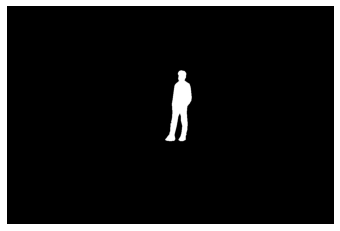

In [ ]:
display_image(img)

In [6]:
img2 = load_img("data/raw/images/ds10_pexels-photo-687782.png")

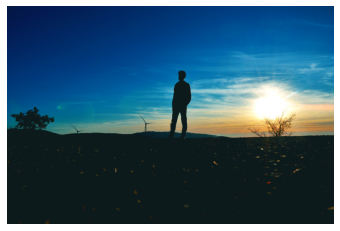

In [7]:
display_image(img2)

### Data Preprocessing

In [8]:
IMAGES_DIR = "data/raw/images/"
MASK_DIR = "data/raw/masks/"

def get_file(_path):
    for (root, dir, files) in os.walk(_path):
        return files

In [9]:
# Split into train, dev and test dataset
train_images, test_images, train_masks, test_masks = train_test_split(get_file(IMAGES_DIR), get_file(MASK_DIR), test_size=0.2)

In [78]:
BATCH_SIZE = 1
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

In [71]:
def prepare_dataset(BASE_DIR, files):
    # find the number of batches
    n_batches = len(files) // BATCH_SIZE
    for i in range(n_batches):
        imgs = list()
        for _file in files[i*BATCH_SIZE:(i*BATCH_SIZE) + BATCH_SIZE]:
            file_path = os.path.join(BASE_DIR,_file)
            img = load_img(file_path)
            img = img.resize((224,224))
            img = img_to_array(img)
            img /= 255.0
            imgs.append(img)
        yield imgs

In [72]:
first_dataset = next(prepare_dataset(IMAGES_DIR, train_images))

### Building Model

In [13]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
vgg_model.trainable = False

In [14]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [54]:
class CNNBlock(layers.Layer):
    def __init__(self,out_channels, kernel_size=2, strides=2, padding="SAME"):
        super(CNNBlock,self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, strides=strides, padding=padding)
        self.batchNorm = layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.batchNorm(x, training = training)
        x = tf.nn.relu()
        return x

In [55]:
class BlockLayer(layers.Layer):
    def __init__(self, out_channels, kernel_size=2, strides=2, padding="SAME",pool_size=2, no_layers = 3):
        super(BlockLayer,self).__init__()
        self.no_layers = no_layers
        self.cnn1 = CNNBlock(out_channels)
        self.cnn2 = CNNBlock(out_channels)
        if self.no_layers == 3:
            self.cnn3 = CNNBlock(out_channels)
        self.upsampling = layers.Conv2DTranspose(out_channels, kernel_size=kernel_size)

    def call(self, input_tensor, training=False):
        x = self.upsampling(input_tensor)
        x = self.cnn1(x)
        x = self.cnn2(x)
        if self.no_layers == 3:
            x = self.cnn3(x)
        return x

In [56]:
class SegNet(models.Model):
    def __init__(self):
        super(SegNet, self).__init__()
        self.encoder = vgg_model
        self.block1 = BlockLayer(14)
        self.block2 = BlockLayer(28)
        self.block3 = BlockLayer(56)
        self.block4 = BlockLayer(112, no_layers=2)
        self.block5 = BlockLayer(224, no_layers=2)
        self.softmax = layers.Softmax()

    def call(self, input_tensor, training = False):
        x = self.encoder(input_tensor)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.softmax(x)
        return x
    
    def model(self):
        x = layers.Input(shape=(224,224,3))
        return models.Model(inputs=[x],outputs = self.call(x))


In [57]:
net = SegNet()

In [76]:
net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [79]:
net.fit(prepare_dataset(IMAGES_DIR, train_images), batch_size=50, epochs=1)

ValueError: ignored

(224, 224, 3)